In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import os
import pathlib
import cv2

# from tensorflow.keras.models import Sequential
from PIL import Image

2023-10-24 14:04:14.918981: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 14:04:15.430379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 2
num_epochs = 5000  # Just for the sake of demonstration
total_timesteps = 1000
norm_groups = 8  # Number of groups used in GroupNormalization layer
learning_rate = 2e-4

# img_size = 64
img_size = 512
img_width = 128
img_channels = 3
clip_min = -1.0
clip_max = 1.0

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

In [3]:
import os
data_path = "/home/aiia/daeun/data/h"
data_dir = pathlib.Path(data_path)
# 현재 디렉토리내에 각각의 파일을 출력

print(os.path.exists(data_dir)) #데이터 경로 확인ㄷ

True


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels=None,
  label_mode= None,
#   validation_split=0.2,
#   seed=1234,
#   subset='training',
  image_size=(img_size, img_width),
  batch_size=None)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   labels=None,
#   label_mode= None,
#   validation_split=0.2,
#   seed=1234,
#   subset='validation',
#   image_size=(img_size, img_width),
#   batch_size=batch_size)

Found 770 files belonging to 1 classes.


2023-10-24 14:04:16.252844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 14:04:16.279966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 14:04:16.280225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
def augment(img):
    """Flips an image left/right randomly."""
    return tf.image.random_flip_left_right(img)


def resize_and_rescale(img, size):
    """Resize the image to the desired size first and then
    rescale the pixel values in the range [-1.0, 1.0].

    Args:
        img: Image tensor
        size: Desired image size for resizing
    Returns:
        Resized and rescaled image tensor
    """

    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    crop_size = tf.minimum(height, width)

    img = tf.image.crop_to_bounding_box(
        img,
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # Resize
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, size=size, antialias=True)

    # Rescale the pixel values
    img = img / 127.5 - 1.0
    img = tf.clip_by_value(img, clip_min, clip_max)
    return img


def train_preprocessing(x):
    img = x#["image"]
    img = resize_and_rescale(img, size=(img_size, img_width))
    img = augment(img)
    return img


train_ds = (
    train_ds.map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
class GaussianDiffusion:
    """Gaussian diffusion utility.

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=-1.0,
        clip_max=1.0,
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

    def _extract(self, a, t, x_shape):
        """Extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.

        Args:
            a: Tensor to extract from
            t: Timestep for which the coefficients are to be extracted
            x_shape: Shape of the current batched samples
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Extracts the mean, and the variance at current timestep.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Diffuse the data.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
            noise: Gaussian noise to be added at the current timestep
        Returns:
            Diffused samples at timestep `t`
        """
        x_start_shape = tf.shape(x_start)
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

In [7]:
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )


class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj


class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb


def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[
            :, None, None, :
        ]

        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb])
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownSample(width):
    def apply(x):
        x = layers.Conv2D(
            width,
            kernel_size=3,
            strides=2,
            padding="same",
            kernel_initializer=kernel_init(1.0),
        )(x)
        return x

    return apply


def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)
        return x

    return apply


def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply


def build_model(
    img_size,
    img_channels,
    widths,
    has_attention,
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
):
    image_input = layers.Input(
        shape=(img_size, img_width, img_channels), name="image_input"
    )
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = layers.Conv2D(
        first_conv_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=kernel_init(1.0),
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)

        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)

        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(3, (3, 3), padding="same", kernel_initializer=kernel_init(0.0))(x)
    return keras.Model([image_input, time_input], x, name="unet")

In [8]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, images):
        # 1. Get the batch size
        batch_size = tf.shape(images)[0]
        # print("batch_size : ",batch_size)
        # batch_size = 32

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)

            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t], training=True)

            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return {"loss": loss}

    def generate_images(self, num_images=16):
        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, img_size, img_width, img_channels), dtype=tf.float32
        )
        # 2. Sample from the model iteratively
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict(
                [samples, tt], verbose=0, batch_size=num_images
            )
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        # 3. Return generated samples
        return samples

    def plot_images(
        self, epoch=None, logs=None, num_rows=1, num_cols=1, figsize=(12, 5)
    ):
        """Utility to plot images using the diffusion model during training."""
        generated_samples = self.generate_images(num_images=num_rows * num_cols)
        generated_samples = (
            tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy()
            .astype(np.uint8)
        )
        img_list = os.listdir('generated_img')
        if len(img_list) == 0:
            c = 0
        else:
            c = len(img_list)
        img_path = os.path.join('generated_img', str(c) + '.jpg')

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            cv2.imwrite(img_path, image)
            print(img_path)

In [9]:
# Build the unet model
network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)
ema_network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same

# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

In [10]:
model = DiffusionModel(network=network, ema_network=ema_network, gdf_util=gdf_util, timesteps=total_timesteps)
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=learning_rate))

2023-10-24 14:04:26.020803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


generated_img/0.jpg
generated_img/2.jpg
generated_img/3.jpg
generated_img/4.jpg
generated_img/5.jpg
generated_img/6.jpg
generated_img/7.jpg
generated_img/8.jpg
generated_img/9.jpg
generated_img/10.jpg
generated_img/11.jpg
generated_img/12.jpg
generated_img/13.jpg
generated_img/14.jpg
generated_img/15.jpg
generated_img/16.jpg
generated_img/17.jpg
generated_img/18.jpg
generated_img/19.jpg
generated_img/20.jpg


/tmp/ipykernel_327758/3635886191.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)


generated_img/21.jpg
generated_img/22.jpg
generated_img/23.jpg
generated_img/24.jpg
generated_img/25.jpg
generated_img/26.jpg
generated_img/27.jpg
generated_img/28.jpg
generated_img/29.jpg
generated_img/30.jpg
generated_img/31.jpg
generated_img/32.jpg
generated_img/33.jpg
generated_img/34.jpg
generated_img/35.jpg
generated_img/36.jpg
generated_img/37.jpg
generated_img/38.jpg
generated_img/39.jpg
generated_img/40.jpg
generated_img/41.jpg
generated_img/42.jpg
generated_img/43.jpg
generated_img/44.jpg


KeyboardInterrupt: 

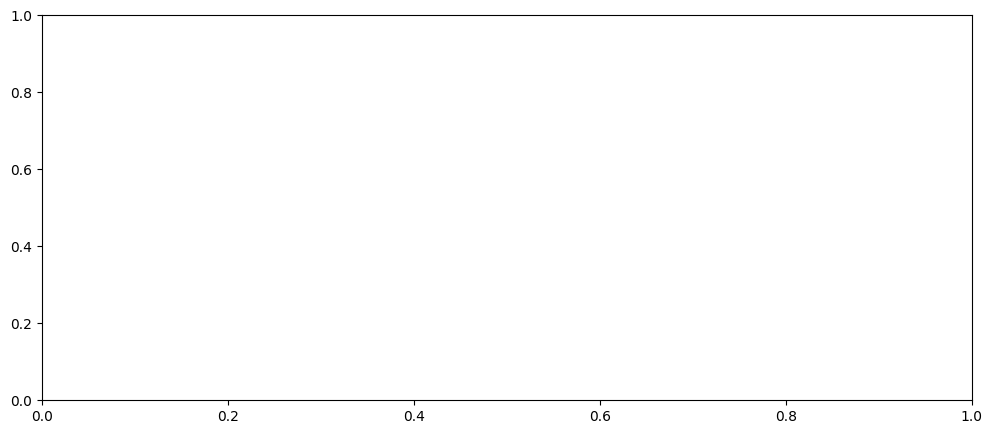

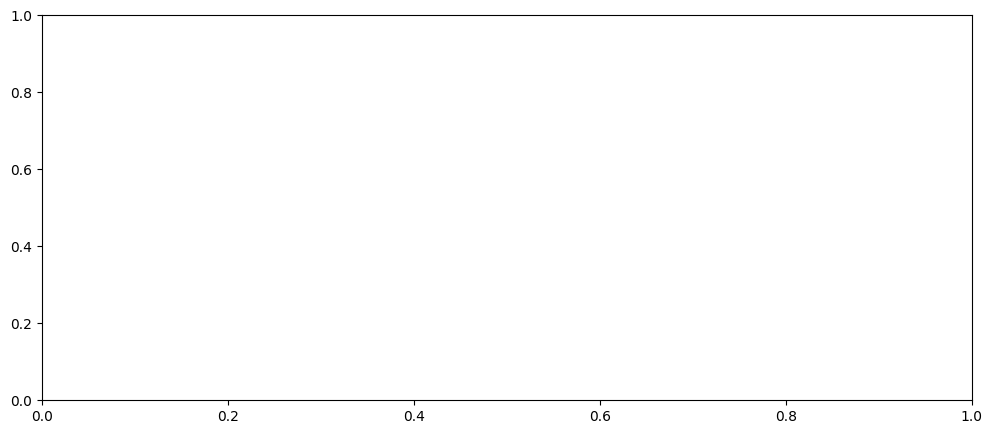

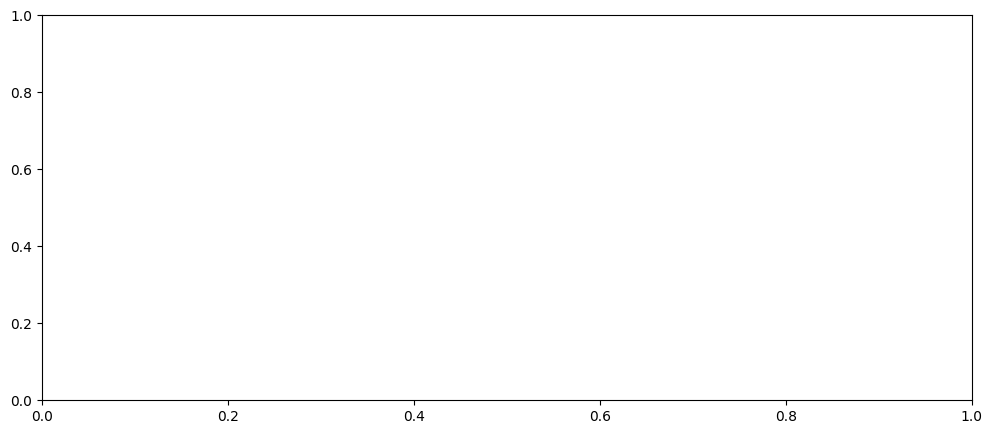

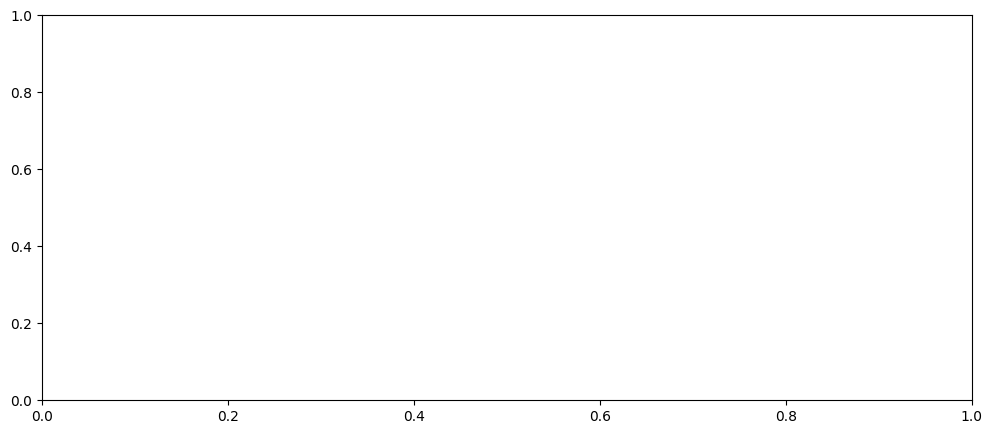

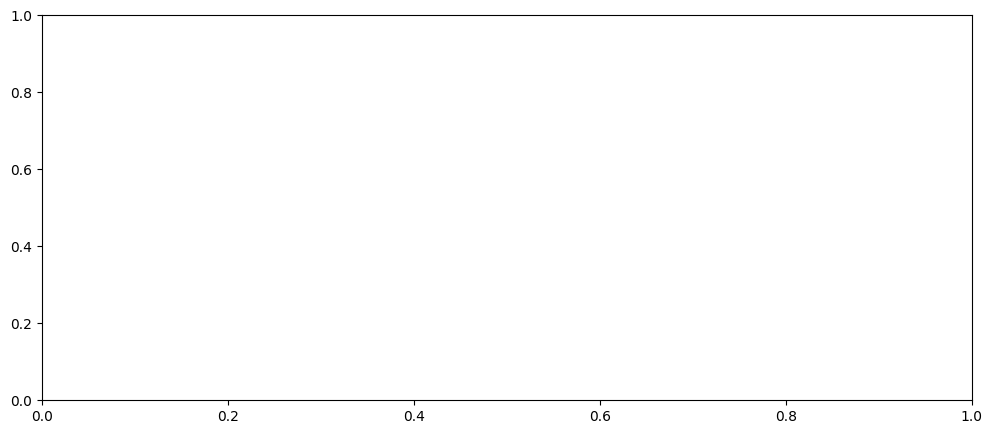

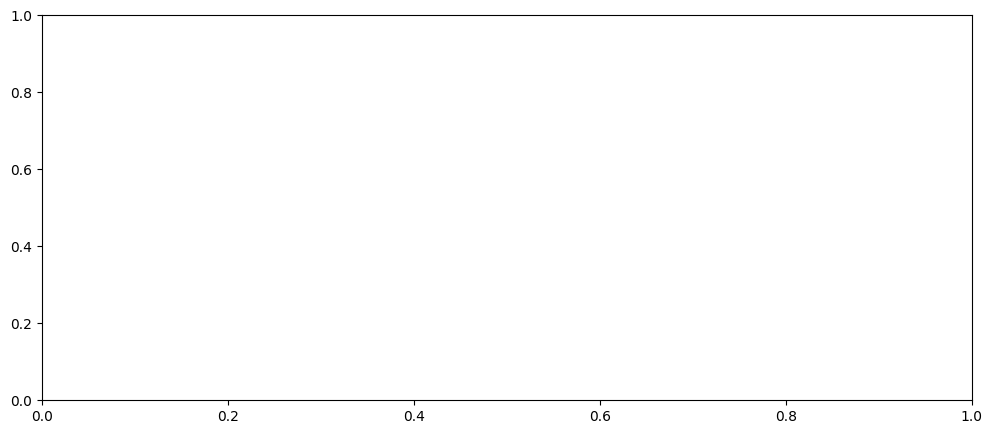

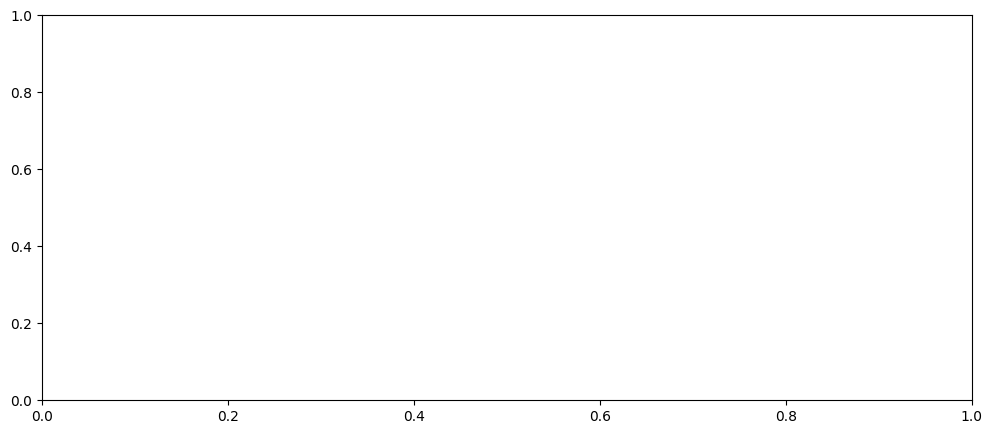

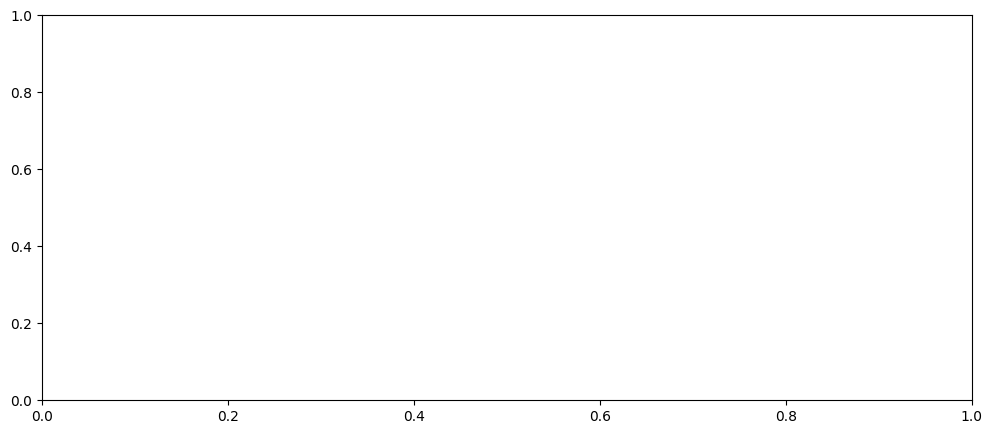

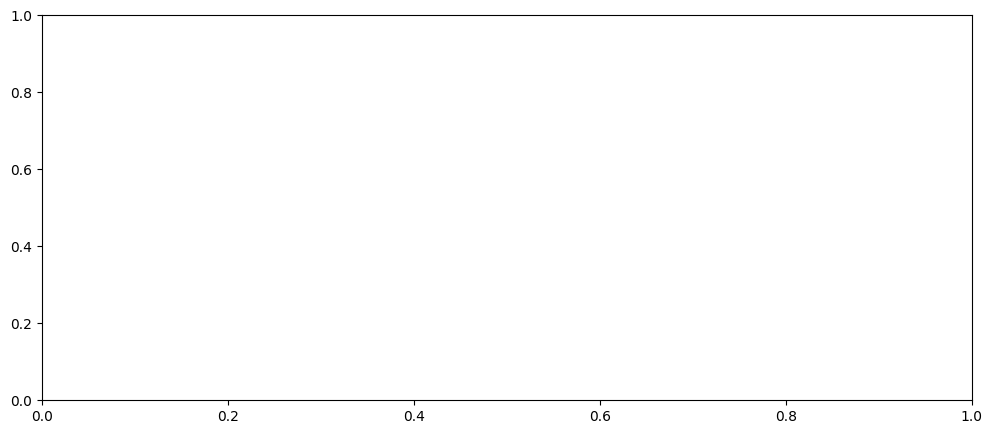

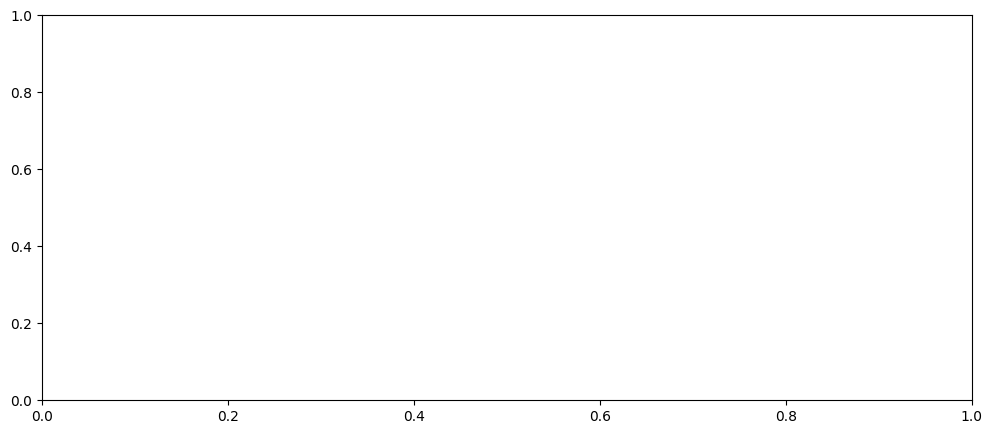

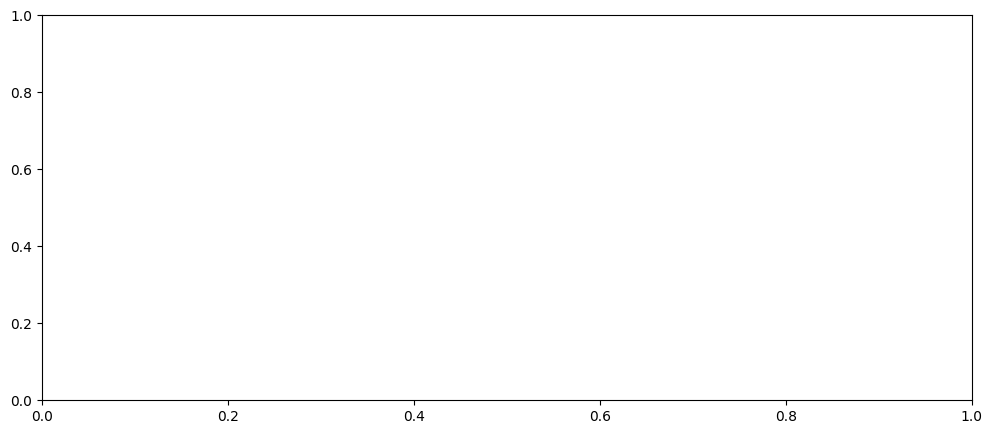

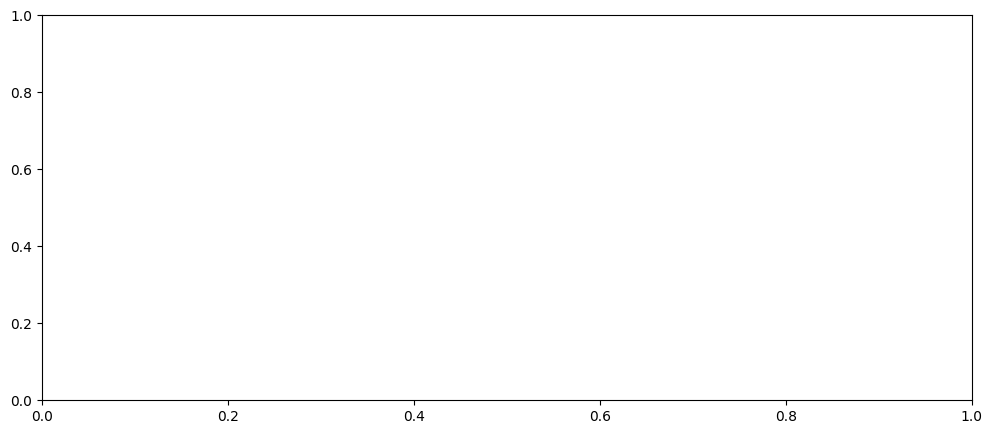

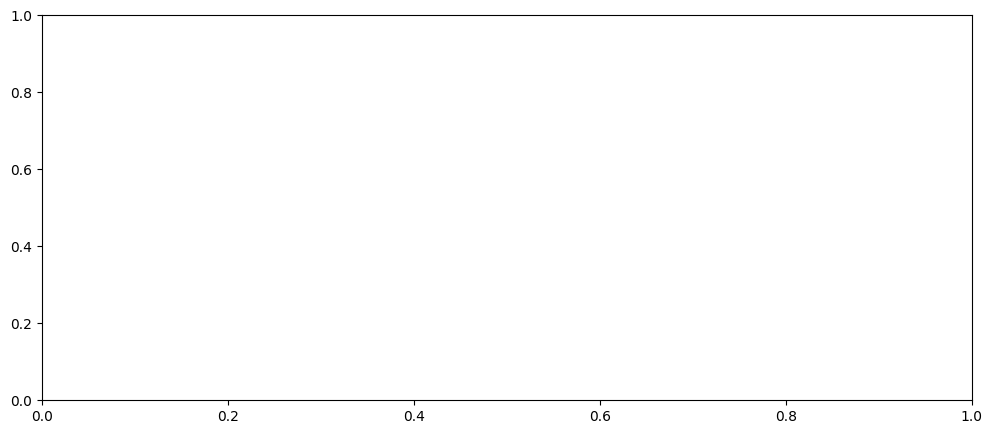

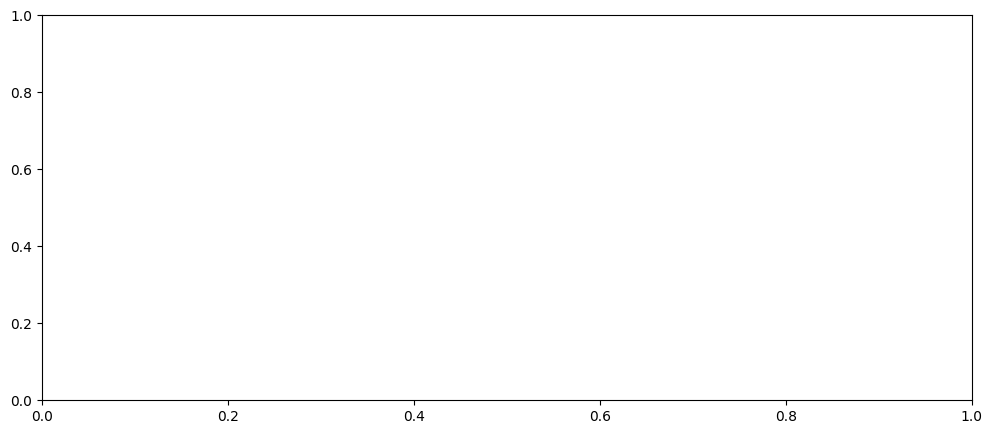

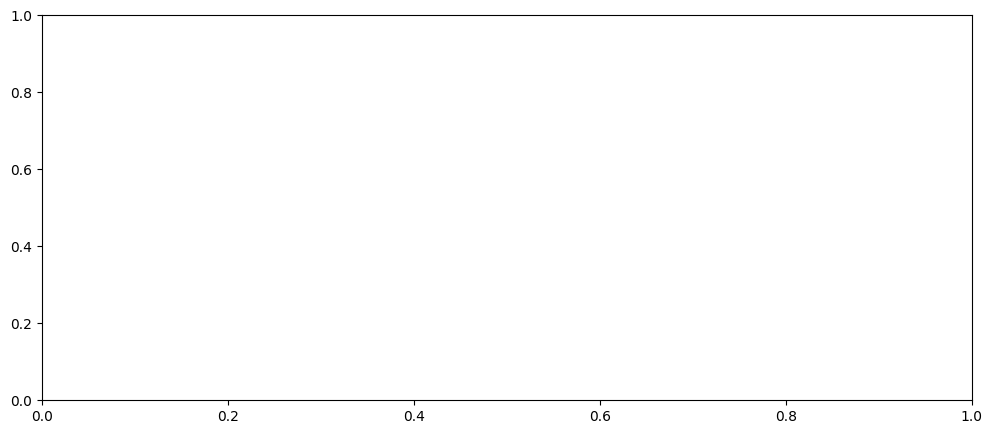

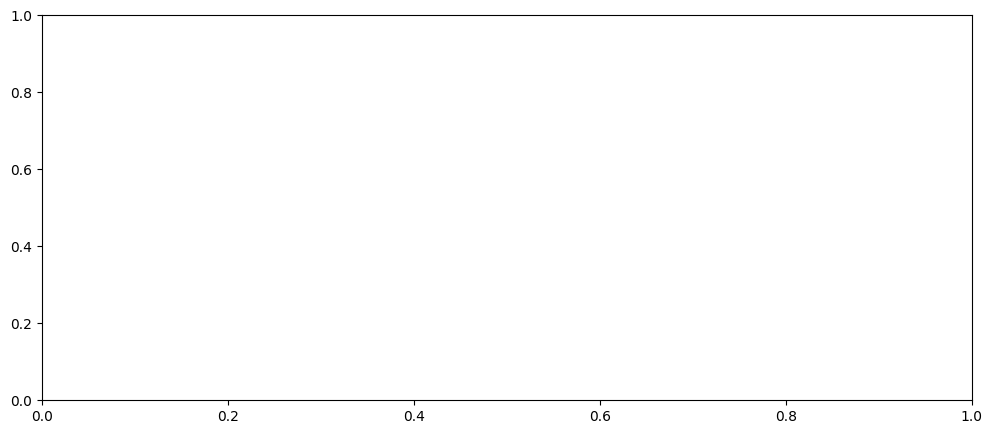

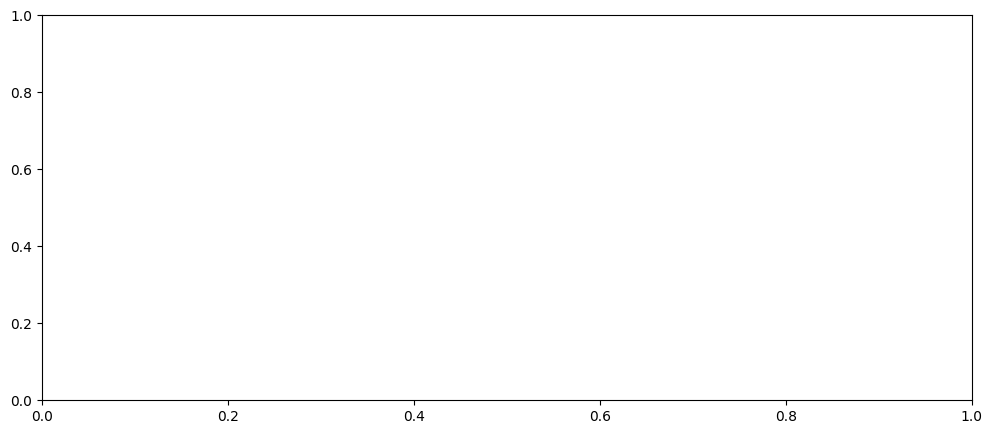

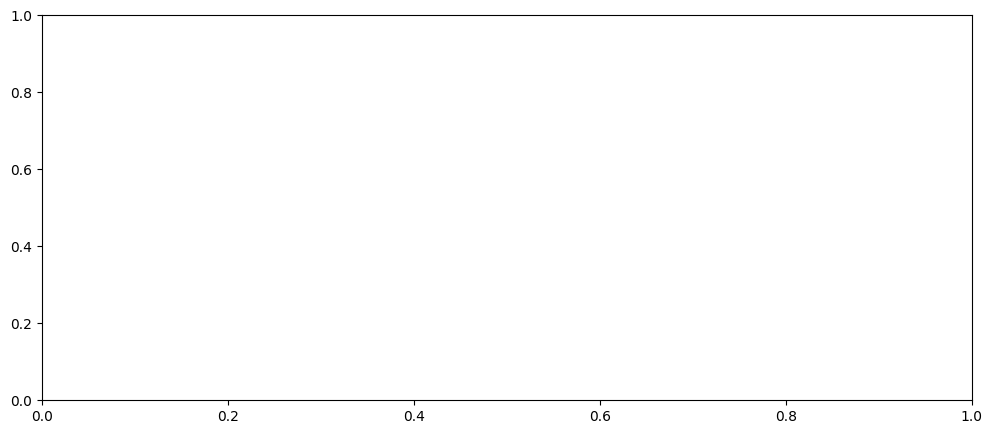

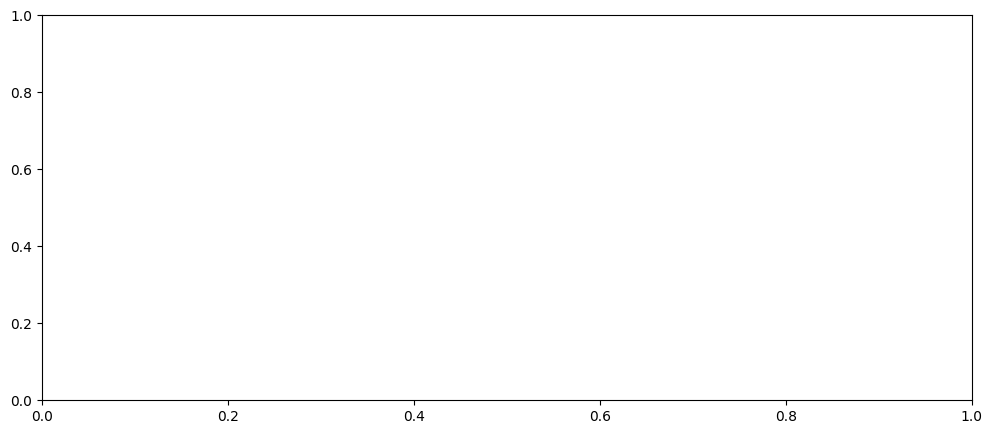

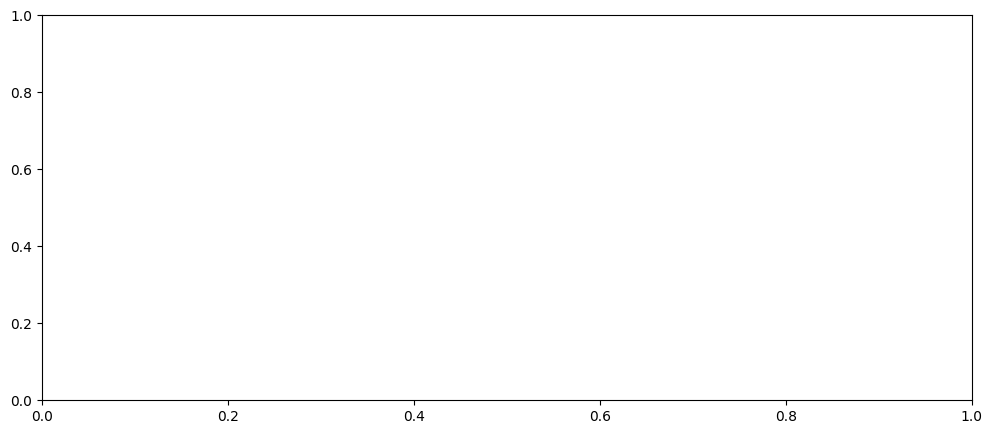

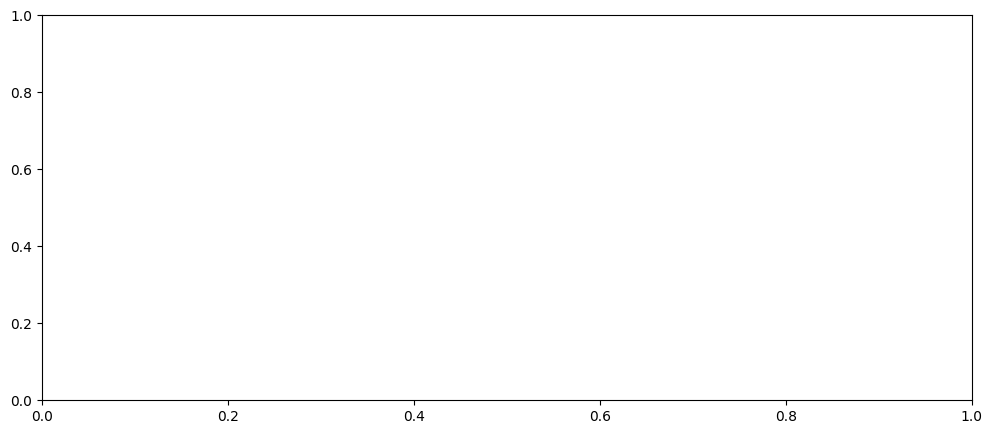

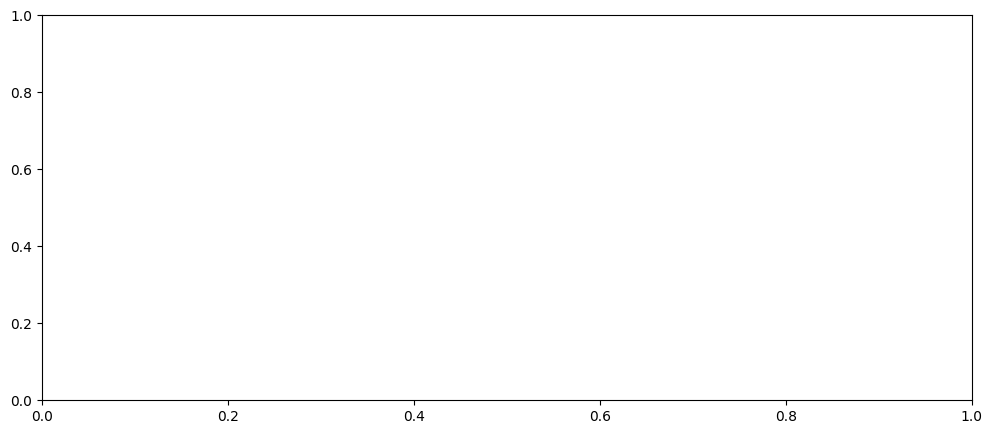

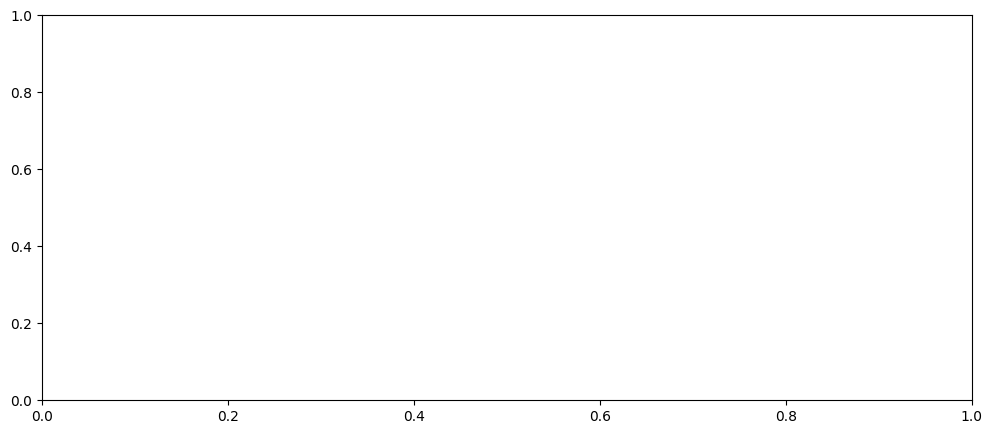

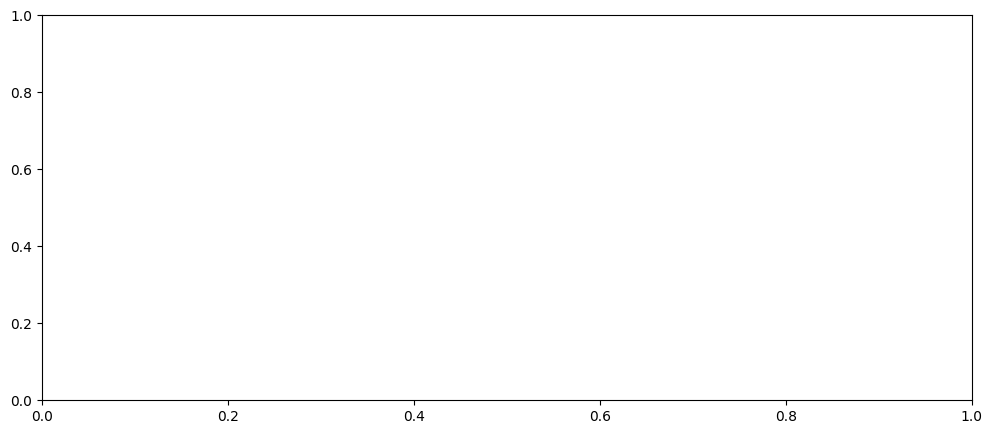

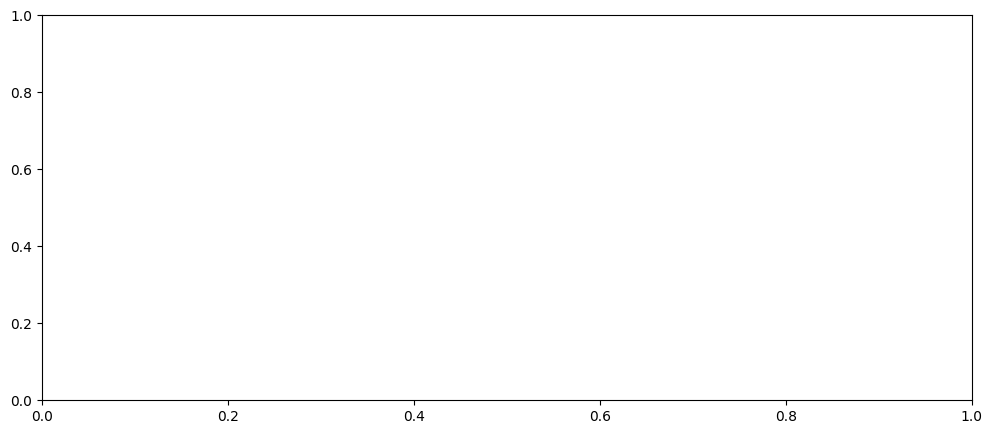

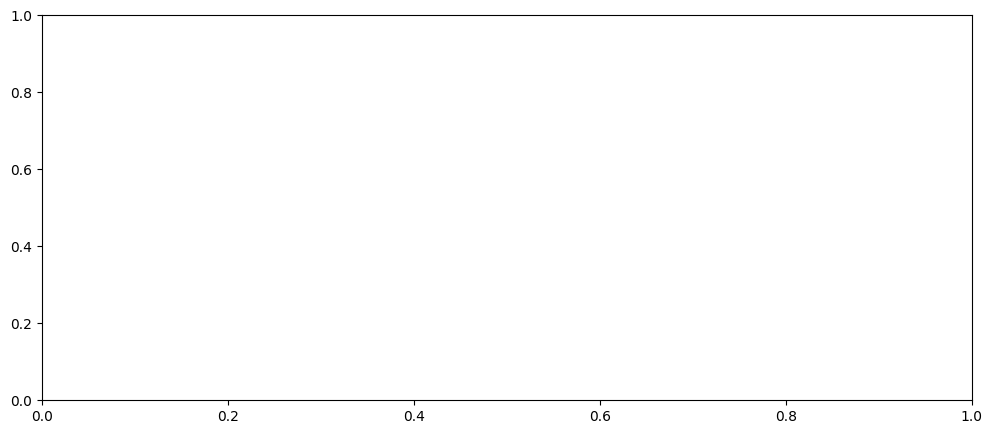

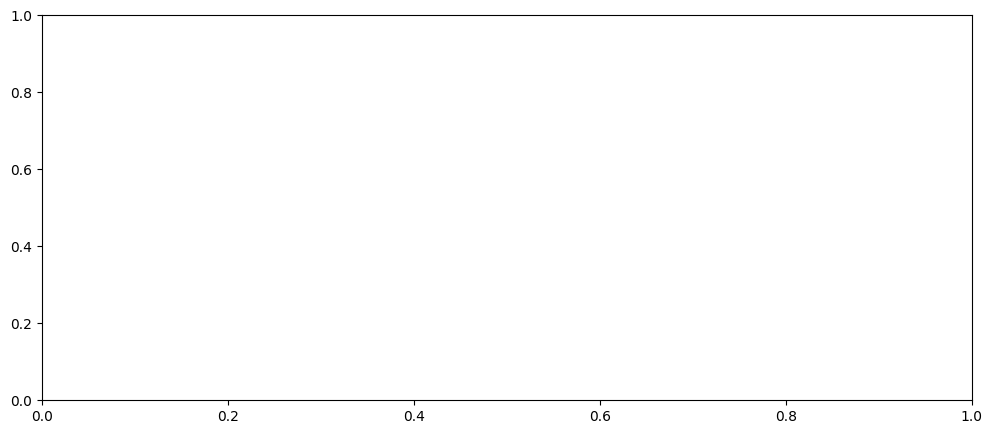

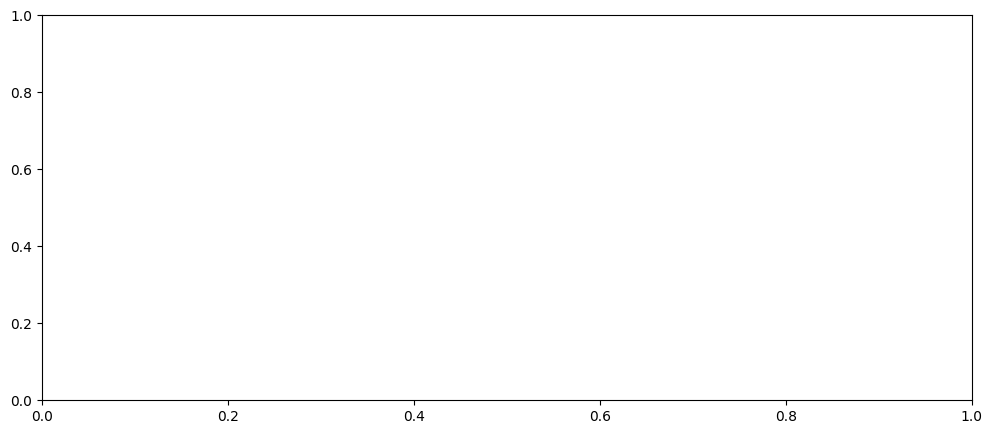

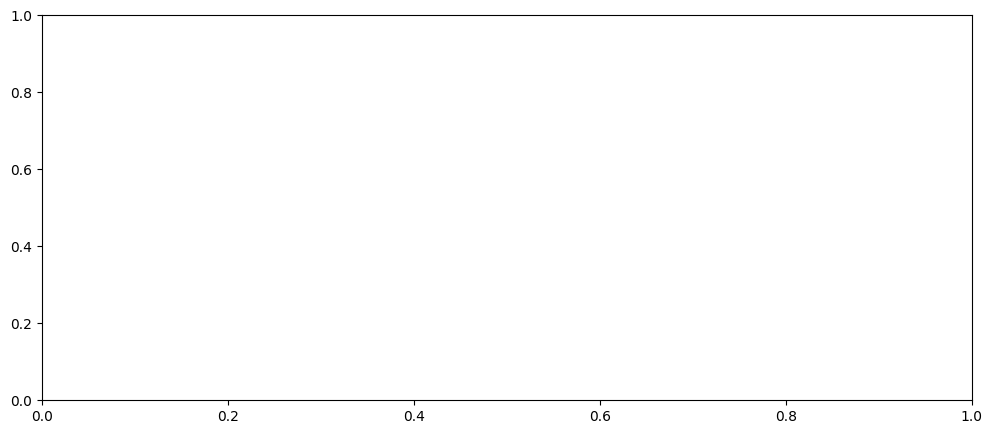

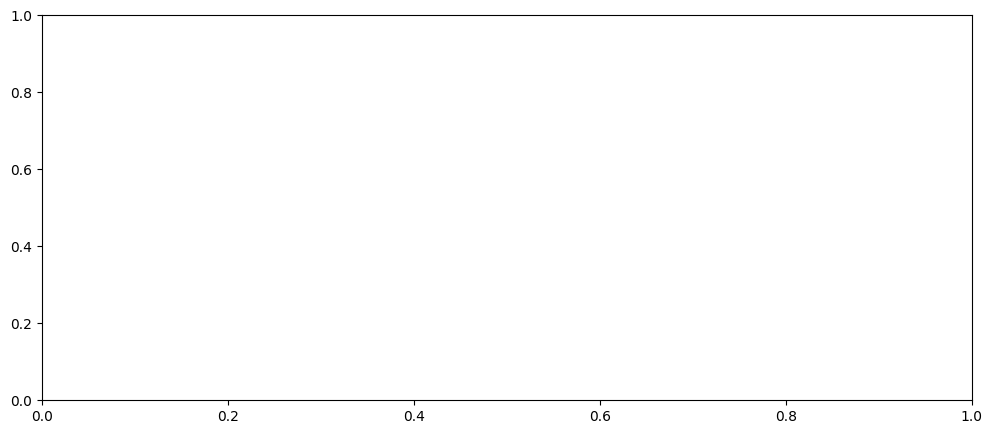

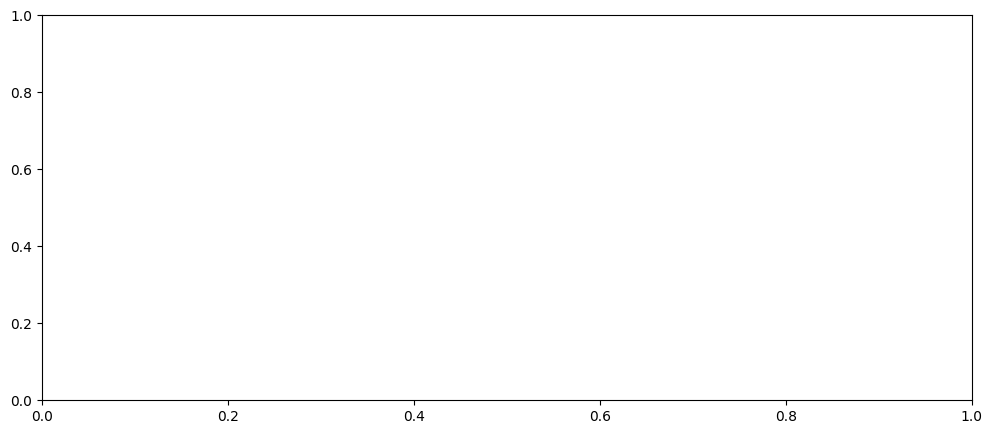

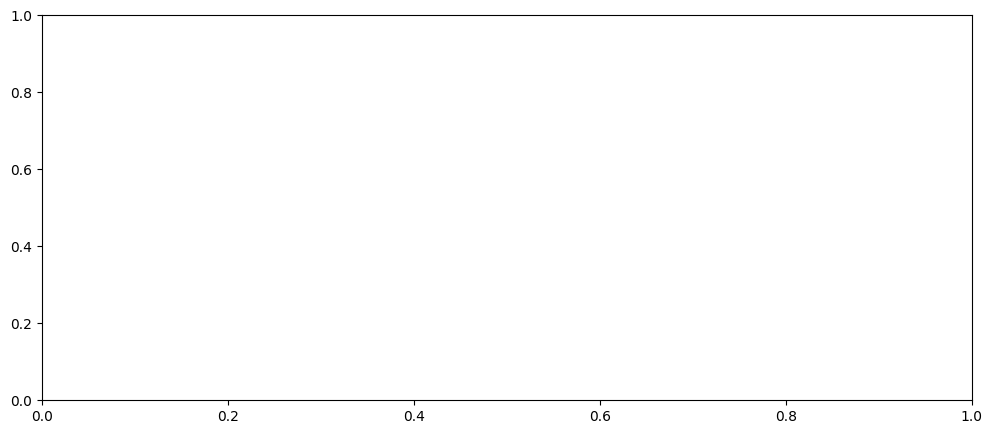

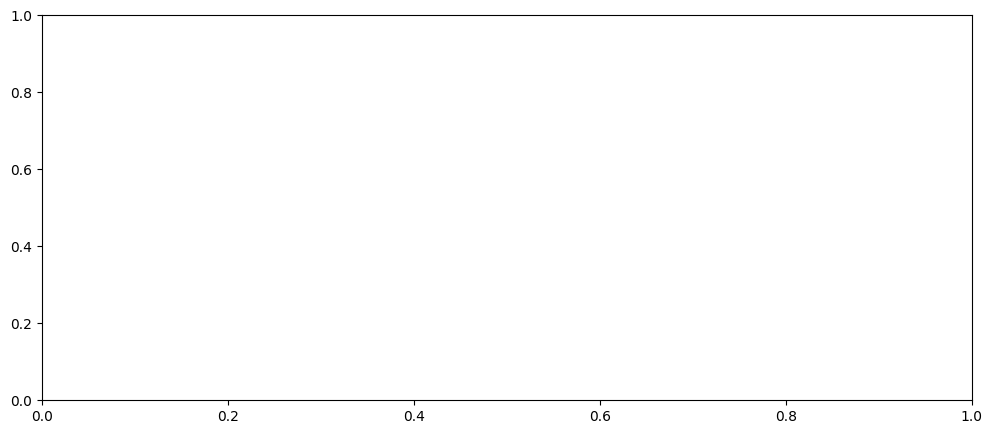

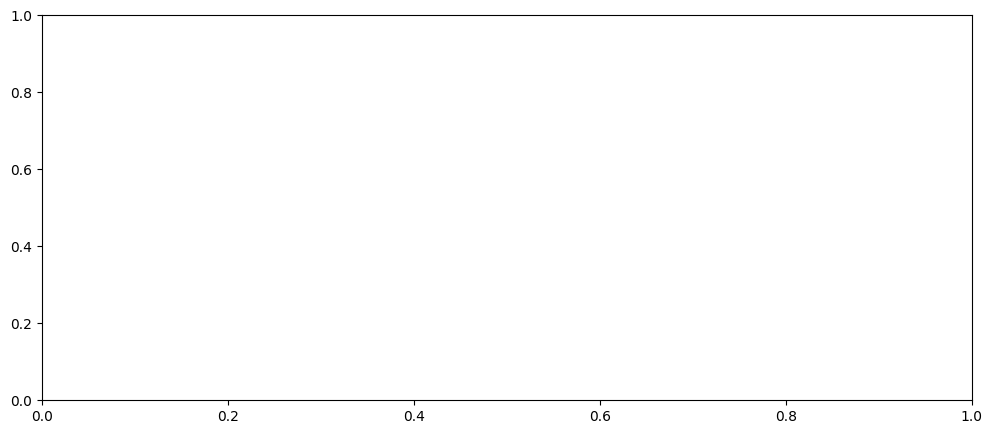

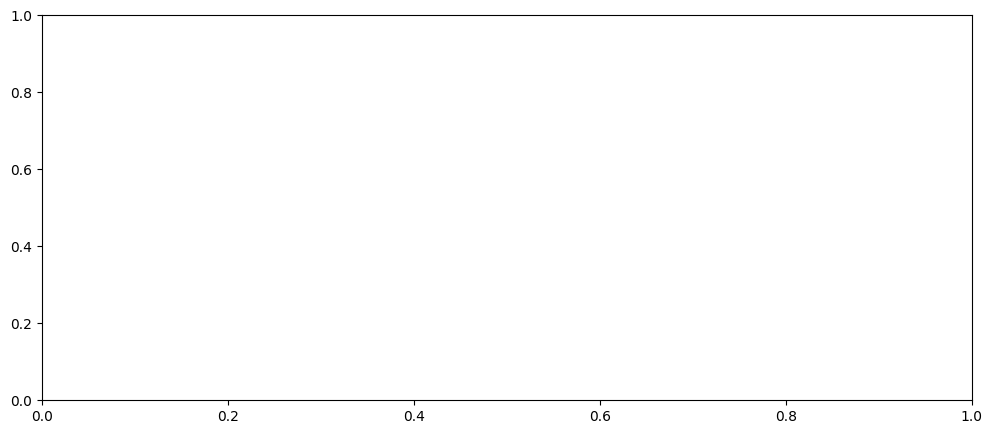

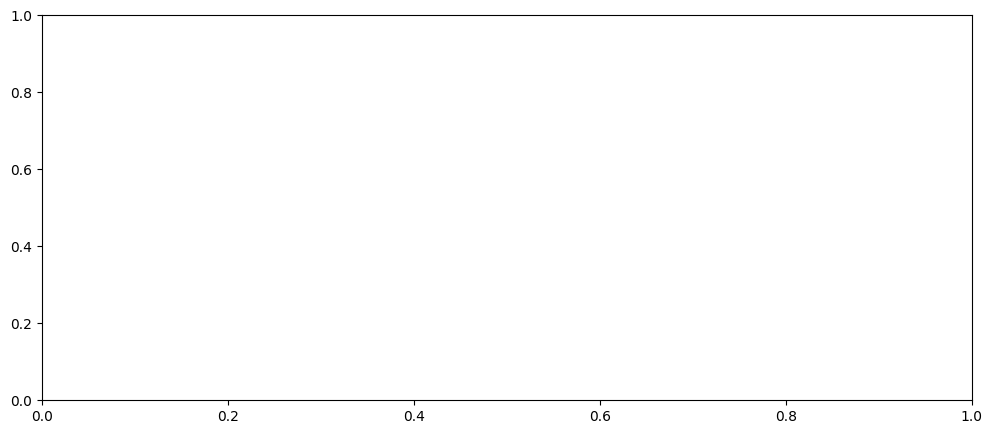

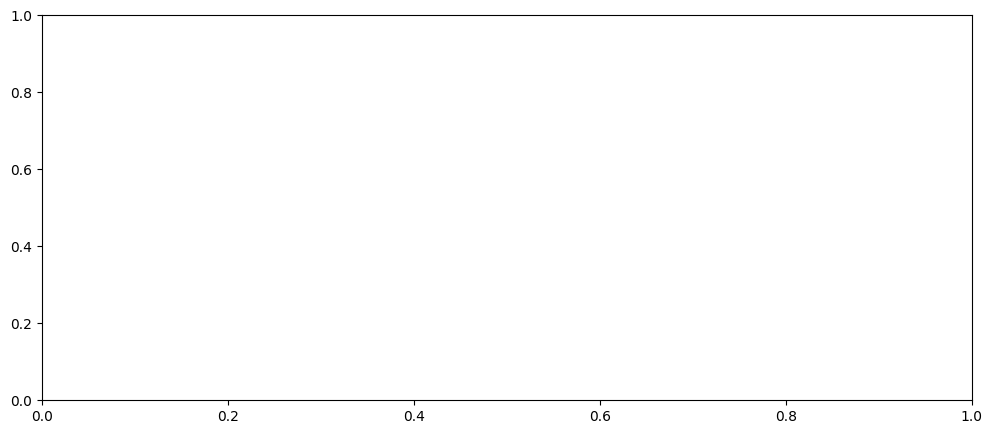

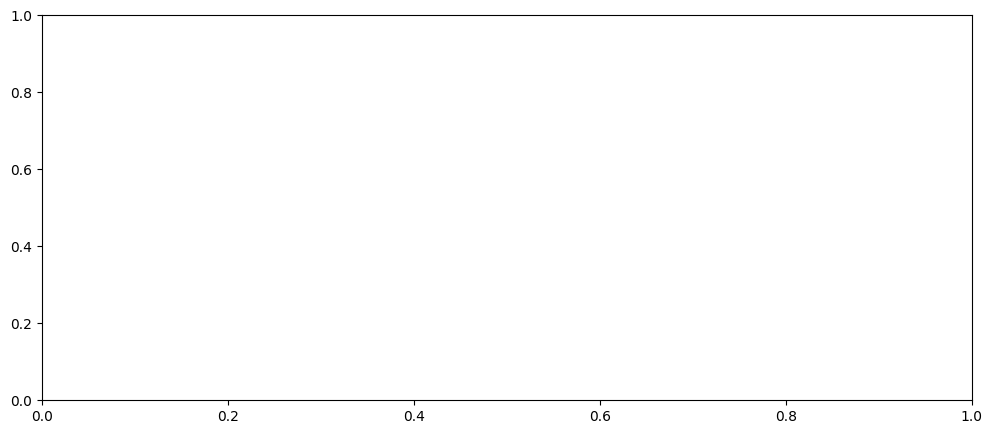

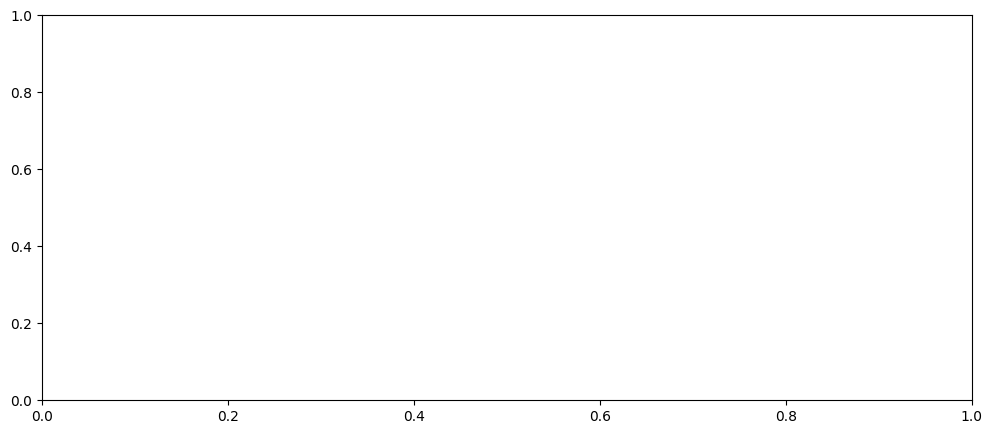

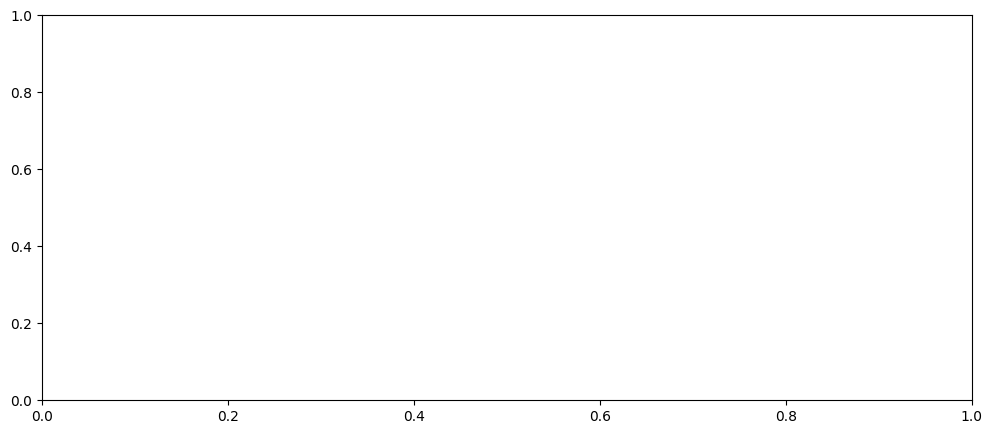

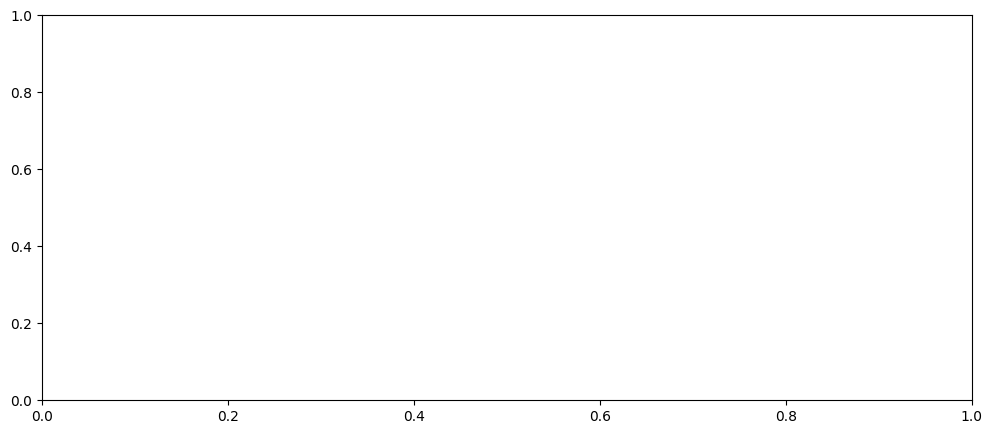

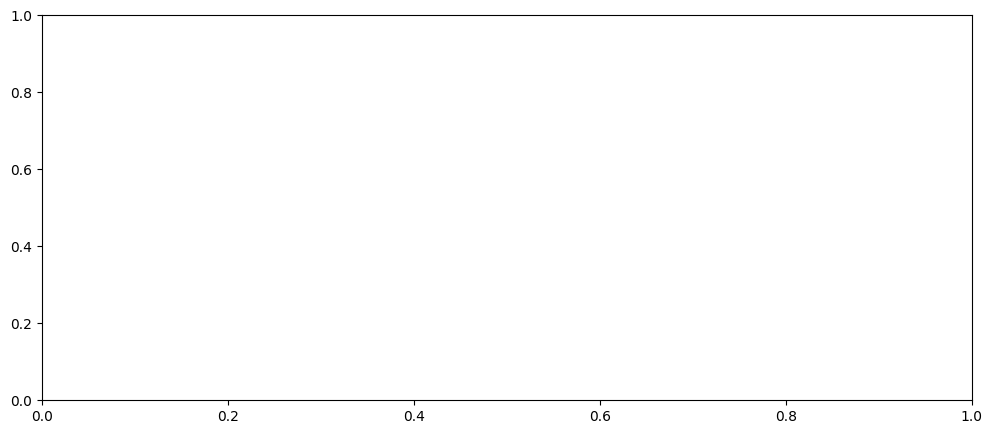

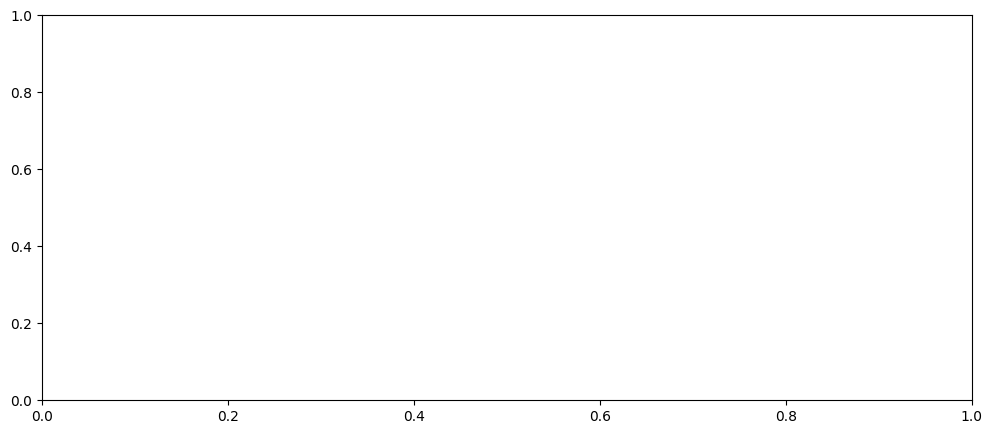

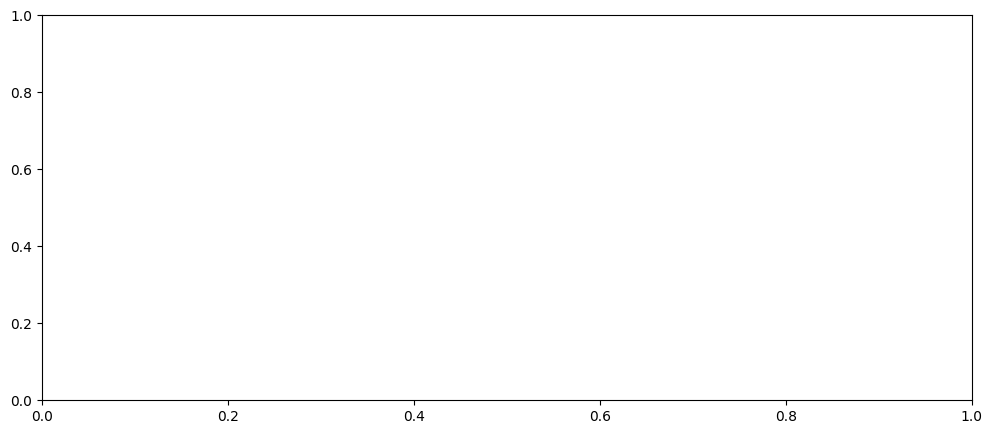

In [11]:
checkpoint_dir = "/home/aiia/daeun/data/save/saved-model-diffusion-2386-0.00"
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(checkpoint_dir)
# Generate and plot some samples
for i in range(600):
    model.plot_images(num_rows=1, num_cols=1)



In [ ]:
reader = tf.train.load_checkpoint(checkpoint_dir)
key = reader.get_variable_to_shape_map()
print(sorted(key.keys()))